## CNN Chest X-Ray RGB Classification Model

ไฟล์นี้เป็นโปรแกรมสำหรับฝึก Deep Learning Model เพื่อจำแนกภาพ Chest X-Ray ระหว่าง Normal (ปกติ) และ Pneumonia (ปอดอักเสบ) โดยใช้รูปภาพ RGB

### ขั้นตอนหลัก:
1. **Import Libraries** - นำเข้าไลบรารี่ที่จำเป็น (PyTorch, Pandas, Matplotlib เป็นต้น)
2. **Load และ Prepare Data** - อ่านข้อมูลจากไฟล์และแบ่งเป็น Train/Validation/Test (4084/870/870)
3. **สร้าง Transform** - เตรียมการแปลงรูปภาพ (ขนาด 224×224, Augmentation สำหรับ training)
4. **สร้าง Dataset และ DataLoader** - สร้าง class สำหรับอ่านข้อมูล และปรับสมดุลคลาส

li

In [1]:
import os
import zipfile
import pandas as pd

import torch
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import recall_score
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch

import imagehash
from PIL import Image
from tqdm import tqdm
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split

## Preparation

In [2]:
from clean import run_cleaning
df_train_new, df_val_new, df_test_new = run_cleaning()
df_train_new.head()


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🚀 START CLEANING PIPELINE                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ STEP 0 — Load DataFrame                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Total files loaded: 5856

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TRAIN — SKIPPED (Cache Found)                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using cached PHASH: Data/cache/clean_phash_train.csv

[INFO] Images: 5190

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ VAL — SKIPPED (Cache Found)                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using cached PHASH: Data/cache/clean_phash_val.csv

[INFO] Images: 16

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TEST — SKIPPED (Cache Found)                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using cached PHASH: Data/cache/clean_phash_test.csv

[INFO] Images: 618

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TRAIN — SKIPPED (RGB Cache Found)                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using RGB cache: Data/cache/clean_rgb_train.csv

[INFO] Images (RGB): 5190

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ VAL — SKIPPED (RGB Cache Found)                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using RGB cache: Data/cache/clean_rgb_val.csv

[INFO] Images (RGB): 16

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TEST — SKIPPED (RGB Cache Found)                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using RGB cache: Data/cache/clean_rgb_test.csv

[INFO] Images (RGB): 618

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TRAIN — SKIPPED (CLAHE Cache Found)                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using CLAHE cache: Data/cache/clean_clahe_train.csv

[INFO] Images (CLAHE): 5190

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ VAL — SKIPPED (CLAHE Cache Found)                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using CLAHE cache: Data/cache/clean_clahe_val.csv

[INFO] Images (CLAHE): 16

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ TEST — SKIPPED (CLAHE Cache Found)                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Using CLAHE cache: Data/cache/clean_clahe_test.csv

[INFO] Images (CLAHE): 618

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🎉 CLEANING COMPLETE                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[INFO] Train images: 5190

[INFO] Val images:   16

[INFO] Test images:  618

,filepath,label
0,Data/chest_xray\train\NORMAL\IM-0115-0001.jpeg,0
1,Data/chest_xray\train\NORMAL\IM-0117-0001.jpeg,0
2,Data/chest_xray\train\NORMAL\IM-0119-0001.jpeg,0
3,Data/chest_xray\train\NORMAL\IM-0122-0001.jpeg,0
4,Data/chest_xray\train\NORMAL\IM-0125-0001.jpeg,0


Data split โดยจะแบ่งข้อมูลเป็น Train 4084 Val 870 Test 870 รวมทั้งหมดเป็น 5824

In [3]:
from data_split import perform_split

df_train_final, df_val_final, df_test_final = perform_split(
    df_train_new,
    df_val_new,
    df_test_new,
    target_val=870,
    target_test=870
)

df_train_new = df_train_final .copy()
df_val_new = df_val_final .copy()
df_test_new = df_test_final .copy()

STEP: Data Split

[INFO] Remaining train images: 5190

[INFO] Need more = 1106 (val 854, test 252)

     SUMMARY     
                 
  Set     Count  
 ─────────────── 
  Train    4084  
  Val       870  
  Test      870  
  Total    5824 

CHECK OVERLAP

✔ No overlaps detected.

In [4]:
df_test_new['label'].value_counts()

label
1    569
0    301
Name: count, dtype: int64

## Transform pytorch

## การสร้าง Transform และ Dataset สำหรับข้อมูล RGB

ในส่วนนี้จะทำการ:

1. **สร้าง Transform สำหรับ RGB** (ขนาด 224×224)
   - `train_transform_rgb_aug` - สำหรับข้อมูล training พร้อมการ Augmentation (พลิก หมุน ย้าย)
   - `train_transform_rgb_noaug` - สำหรับข้อมูล training โดยไม่มี Augmentation
   - `val_test_transform_rgb` - สำหรับข้อมูล validation และ test (ไม่มี Augmentation)

2. **สร้าง XrayDataset Class** - Class สำหรับอ่านรูปภาพและ label จากไฟล์

3. **สร้าง Balance Function** - ฟังก์ชันสำหรับปรับสมดุลข้อมูล (เพิ่มข้อมูลคลาส Normal และ Pneumonia ให้มีจำนวนใกล้เคียงกัน)

4. **สร้าง Dataset Objects**
   - สำหรับ Training: ข้อมูล Augmented และ Non-Augmented
   - สำหรับ Validation และ Test: ข้อมูล Non-Augmented

5. **สร้าง DataLoader** - เตรียมข้อมูลเป็น batch ขนาด 128 เพื่อใช้ในการฝึกและรองรับ pytorch


In [5]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# (A) RGB -------------------------------------------------------------------------
train_transform_rgb_aug = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(12),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

train_transform_rgb_noaug = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

val_test_transform_rgb = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# (B) Grayscale -------------------------------------------------------------------
train_transform_gray_aug = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(12),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_transform_gray_noaug = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [6]:
class XrayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.filepaths = df["filepath"].values
        self.labels = df["label"].values
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = torch.tensor(self.labels[idx]).long()
        with Image.open(img_path) as img:
            if self.transform:
                img = self.transform(img)
        return img, label


def balance_dataset_keep_original(df, target_0=3200, target_1=3500):
    """
    ทำ balancing แบบ 'เพิ่มเฉพาะจำนวนที่ขาด'
    - original ไม่โดนแก้
    - aug จะทำเฉพาะข้อมูลที่เพิ่มเข้ามา (clone)
    """

    df0 = df[df["label"] == 0]
    df1 = df[df["label"] == 1]

    n0, n1 = len(df0), len(df1)
    print(f"Before: class0={n0}, class1={n1} → total={len(df)}")

    # คำนวณจำนวนที่ต้องเพิ่ม
    add0 = max(target_0 - n0, 0)
    add1 = max(target_1 - n1, 0)

    # เพิ่มแบบ sampling (augmentation จะไปเกิดใน transform)
    df0_aug = df0.sample(add0, replace=True, random_state=42) if add0 > 0 else pd.DataFrame(columns=df.columns)
    df1_aug = df1.sample(add1, replace=True, random_state=42) if add1 > 0 else pd.DataFrame(columns=df.columns)

    # รวม original + aug clones
    df_final = pd.concat([df, df0_aug, df1_aug], axis=0)
    df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"After : class0={n0 + len(df0_aug)}, class1={n1 + len(df1_aug)} → total={len(df_final)}")

    return df_final



In [8]:
df_train_balanced = balance_dataset_keep_original(df_train_new, target_0=2950, target_1=0)

# -------------------- RGB --------------------
train_ds_rgb_aug     = XrayDataset(df_train_balanced, transform=train_transform_rgb_aug)
train_ds_rgb_noaug   = XrayDataset(df_train_new, transform=train_transform_rgb_noaug)
val_ds_rgb           = XrayDataset(df_val_new, transform=val_test_transform_rgb)
test_ds_rgb          = XrayDataset(df_test_new, transform=val_test_transform_rgb)

# -------------------- Grayscale --------------------
train_ds_gray_aug    = XrayDataset(df_train_balanced, transform=train_transform_gray_aug)
train_ds_gray_noaug  = XrayDataset(df_train_new, transform=train_transform_gray_noaug)
val_ds_gray          = XrayDataset(df_val_new, transform=val_test_transform_gray)
test_ds_gray         = XrayDataset(df_test_new, transform=val_test_transform_gray)


Before: class0=1054, class1=3030 → total=4084
After : class0=2950, class1=3030 → total=5980


## Model config

## ตั้งค่า Model และเริ่มการฝึก

ในส่วนนี้จะทำการ:
1. **ตั้งค่า DataLoader** - ตั้ง batch_size เป็น 128 สำหรับการอ่านข้อมูล grayscale
2. **สร้าง TinyCNN Model** - สร้าง Convolutional Neural Network ที่ยอมรับ input ขนาด 1 channel (grayscale)
3. **ตั้ง Loss Function และ Optimizer** - ใช้ BCEWithLogitsLoss สำหรับ binary classification และ Adam optimizer ในการปรับค่า weight
4. **ฝึก Model ด้วย Early Stopping** - ฝึก model จนถึง 50 epochs โดยจะหยุดก่อนเวลาถ้าผลลัพธ์ไม่ดีขึ้นเป็น 5 epochs ติดต่อกัน
5. **บันทึก Checkpoint** - เก็บ model ที่ดีที่สุด (validation loss ต่ำสุด) ไว้เป็นไฟล์

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models


In [18]:
batch_size = 128

# --- RGB ---   
train_loader_rgb_aug    = DataLoader(train_ds_rgb_aug, batch_size=batch_size, shuffle=True, num_workers=0)   
train_loader_rgb_noaug  = DataLoader(train_ds_rgb_noaug, batch_size=batch_size, shuffle=True, num_workers=0)   
val_loader_rgb          = DataLoader(val_ds_rgb, batch_size=batch_size, shuffle=False, num_workers=0)   
test_loader_rgb         = DataLoader(test_ds_rgb, batch_size=batch_size, shuffle=False, num_workers=0)  


# ใช้ TinyCNN - CNN ขนาดเล็กสำหรับ Binary Classification




In [ ]:
class TinyCNN(nn.Module):
    def __init__(self):
        super(TinyCNN, self).__init__()
        # --- Convolutional layers ---
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)   
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)  
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.3)

        # --- Fully connected layers ---
        self.fc1 = nn.Linear(16*56*56, 64)  
        self.fc2 = nn.Linear(64, 1)         

        # --- ReLU layer ---
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)  
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TinyCNN().to(device)
print(model)


TinyCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=50176, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU(inplace=True)
)


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TinyCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [21]:
from sklearn.metrics import recall_score
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
import numpy as np
import torch

In [ ]:
# -------------------- Early Stopping --------------------

train_losses_aug = []
train_accuracies_aug = []
train_recalls_aug = []
val_losses_aug = []
val_accuracies_aug = []
val_recalls_aug = []

num_epochs = 50
patience = 5  
counter = 0    
best_val_loss = float('inf')
checkpoint_path = 'best_model_aug.pth'

for epoch in range(num_epochs):
    # -------------------- Train --------------------
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    all_preds, all_labels = [], []

    train_loop = tqdm(train_loader_rgb_aug, desc=f"Epoch [{epoch+1}/{num_epochs}] Train", leave=False)
    for images, labels in train_loop:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

        train_loop.set_postfix(loss=loss.item(), acc=correct/total)

    train_loss = running_loss / total
    train_acc = correct / total
    train_recall = recall_score(all_labels, all_preds, zero_division=0)
    train_losses_aug.append(train_loss)
    train_accuracies_aug.append(train_acc)
    train_recalls_aug.append(train_recall)

    # -------------------- Validation --------------------
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    val_preds, val_labels = [], []

    val_loop = tqdm(val_loader_rgb, desc=f"Epoch [{epoch+1}/{num_epochs}] Val  ", leave=False)
    with torch.no_grad():
        for images, labels in val_loop:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            val_preds.extend(preds.cpu().numpy().flatten())
            val_labels.extend(labels.cpu().numpy().flatten())

            val_loop.set_postfix(loss=loss.item(), acc=val_correct/val_total)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_recall = recall_score(val_labels, val_preds, zero_division=0)
    val_losses_aug.append(val_loss)
    val_accuracies_aug.append(val_acc)
    val_recalls_aug.append(val_recall)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Recall: {train_recall:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Recall: {val_recall:.4f}")

    # -------------------- Checkpoint --------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_recall': val_recall
        }, checkpoint_path)
        print(f" Checkpoint saved at epoch {epoch+1} (Val Loss: {val_loss:.4f})")
    else:
        counter += 1
        print(f" No improvement for {counter} epoch(s)")

    # -------------------- Early Stopping --------------------
    if counter >= patience:
        print(f" Early stopping at epoch {epoch+1}. Best Val Loss: {best_val_loss:.4f}")
        break


Epoch [1/50] Train Loss: 0.4072, Train Acc: 0.8338, Train Recall: 0.8234 | Val Loss: 0.3064, Val Acc: 0.8678, Val Recall: 0.8375
✅ Checkpoint saved at epoch 1 (Val Loss: 0.3064)


Epoch [2/50] Train Loss: 0.2350, Train Acc: 0.9077, Train Recall: 0.8957 | Val Loss: 0.2685, Val Acc: 0.8908, Val Recall: 0.8576
✅ Checkpoint saved at epoch 2 (Val Loss: 0.2685)


Epoch [3/50] Train Loss: 0.1999, Train Acc: 0.9221, Train Recall: 0.9079 | Val Loss: 0.1455, Val Acc: 0.9483, Val Recall: 0.9628
✅ Checkpoint saved at epoch 3 (Val Loss: 0.1455)


Epoch [4/50] Train Loss: 0.1868, Train Acc: 0.9289, Train Recall: 0.9198 | Val Loss: 0.1913, Val Acc: 0.9230, Val Recall: 0.9056
⚠️ No improvement for 1 epoch(s)


Epoch [5/50] Train Loss: 0.1678, Train Acc: 0.9401, Train Recall: 0.9304 | Val Loss: 0.1717, Val Acc: 0.9356, Val Recall: 0.9226
⚠️ No improvement for 2 epoch(s)


Epoch [6/50] Train Loss: 0.1789, Train Acc: 0.9301, Train Recall: 0.9201 | Val Loss: 0.1559, Val Acc: 0.9379, Val Recall: 0.9350
⚠️ No improvement for 3 epoch(s)


Epoch [7/50] Train Loss: 0.1619, Train Acc: 0.9388, Train Recall: 0.9300 | Val Loss: 0.1955, Val Acc: 0.9207, Val Recall: 0.8994
⚠️ No improvement for 4 epoch(s)


Epoch [8/50] Train Loss: 0.1551, Train Acc: 0.9470, Train Recall: 0.9373 | Val Loss: 0.1750, Val Acc: 0.9333, Val Recall: 0.9211
⚠️ No improvement for 5 epoch(s)
⛔ Early stopping at epoch 8. Best Val Loss: 0.1455


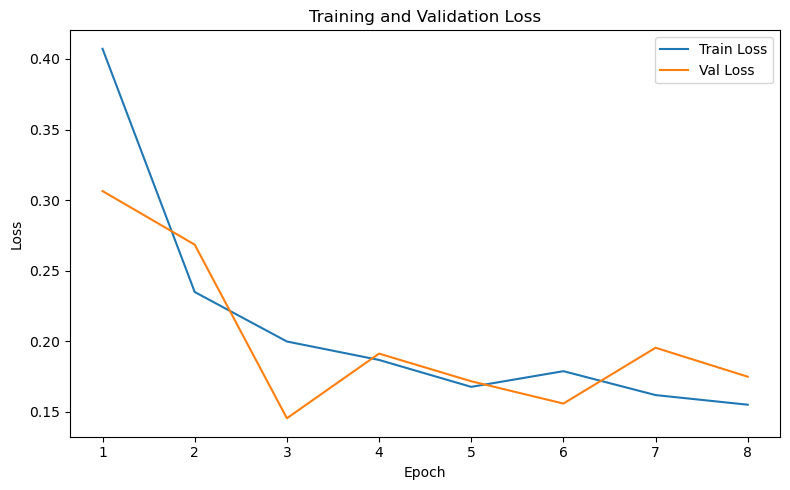

In [ ]:
def plot_training_history():
    epochs = range(1, len(train_losses_aug) + 1)  

    plt.figure(figsize=(8, 5))

    # ---- Loss ----
    plt.subplot(1, 1, 1)
    plt.plot(epochs, train_losses_aug, label='Train Loss')
    plt.plot(epochs, val_losses_aug, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_history()


In [ ]:
# -------------------- Early Stopping --------------------

train_losses_noaug = []
train_accuracies_noaug = []
train_recalls_noaug = []
val_losses_noaug = []
val_accuracies_noaug = []
val_recalls_noaug = []

num_epochs = 50
patience = 5  
counter = 0    
best_val_loss = float('inf')
checkpoint_path = 'best_model_noaug.pth'

for epoch in range(num_epochs):
    # -------------------- Train --------------------
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    all_preds, all_labels = [], []

    train_loop = tqdm(train_loader_rgb_noaug, desc=f"Epoch [{epoch+1}/{num_epochs}] Train", leave=False)
    for images, labels in train_loop:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

        train_loop.set_postfix(loss=loss.item(), acc=correct/total)

    train_loss = running_loss / total
    train_acc = correct / total
    train_recall = recall_score(all_labels, all_preds, zero_division=0)
    train_losses_noaug.append(train_loss)
    train_accuracies_noaug.append(train_acc)
    train_recalls_noaug.append(train_recall)

    # -------------------- Validation --------------------
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    val_preds, val_labels = [], []

    val_loop = tqdm(val_loader_rgb, desc=f"Epoch [{epoch+1}/{num_epochs}] Val  ", leave=False)
    with torch.no_grad():
        for images, labels in val_loop:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            val_preds.extend(preds.cpu().numpy().flatten())
            val_labels.extend(labels.cpu().numpy().flatten())

            val_loop.set_postfix(loss=loss.item(), acc=val_correct/val_total)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_recall = recall_score(val_labels, val_preds, zero_division=0)
    val_losses_noaug.append(val_loss)
    val_accuracies_noaug.append(val_acc)
    val_recalls_noaug.append(val_recall)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Recall: {train_recall:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Recall: {val_recall:.4f}")

    # -------------------- Checkpoint --------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_recall': val_recall
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1} (Val Loss: {val_loss:.4f})")
    else:
        counter += 1
        print(f"No improvement for {counter} epoch(s)")

    # -------------------- Early Stopping --------------------
    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best Val Loss: {best_val_loss:.4f}")
        break


Epoch [1/50] Train Loss: 0.4216, Train Acc: 0.7968, Train Recall: 0.9776 | Val Loss: 0.2568, Val Acc: 0.9287, Val Recall: 0.9892
Checkpoint saved at epoch 1 (Val Loss: 0.2568)


Epoch [2/50] Train Loss: 0.2109, Train Acc: 0.9327, Train Recall: 0.9792 | Val Loss: 0.1478, Val Acc: 0.9552, Val Recall: 0.9861
Checkpoint saved at epoch 2 (Val Loss: 0.1478)


Epoch [3/50] Train Loss: 0.1457, Train Acc: 0.9496, Train Recall: 0.9746 | Val Loss: 0.1181, Val Acc: 0.9586, Val Recall: 0.9876
Checkpoint saved at epoch 3 (Val Loss: 0.1181)


Epoch [4/50] Train Loss: 0.1231, Train Acc: 0.9574, Train Recall: 0.9762 | Val Loss: 0.0999, Val Acc: 0.9655, Val Recall: 0.9799
Checkpoint saved at epoch 4 (Val Loss: 0.0999)


Epoch [5/50] Train Loss: 0.1087, Train Acc: 0.9633, Train Recall: 0.9805 | Val Loss: 0.0995, Val Acc: 0.9655, Val Recall: 0.9876
Checkpoint saved at epoch 5 (Val Loss: 0.0995)


Epoch [6/50] Train Loss: 0.0966, Train Acc: 0.9660, Train Recall: 0.9812 | Val Loss: 0.0939, Val Acc: 0.9667, Val Recall: 0.9861
Checkpoint saved at epoch 6 (Val Loss: 0.0939)


Epoch [7/50] Train Loss: 0.0921, Train Acc: 0.9657, Train Recall: 0.9815 | Val Loss: 0.0868, Val Acc: 0.9690, Val Recall: 0.9845
Checkpoint saved at epoch 7 (Val Loss: 0.0868)


Epoch [8/50] Train Loss: 0.0825, Train Acc: 0.9736, Train Recall: 0.9868 | Val Loss: 0.0884, Val Acc: 0.9713, Val Recall: 0.9876
No improvement for 1 epoch(s)


Epoch [9/50] Train Loss: 0.0761, Train Acc: 0.9736, Train Recall: 0.9845 | Val Loss: 0.0933, Val Acc: 0.9632, Val Recall: 0.9613
No improvement for 2 epoch(s)


Epoch [10/50] Train Loss: 0.0806, Train Acc: 0.9709, Train Recall: 0.9825 | Val Loss: 0.0827, Val Acc: 0.9678, Val Recall: 0.9814
Checkpoint saved at epoch 10 (Val Loss: 0.0827)


Epoch [11/50] Train Loss: 0.0680, Train Acc: 0.9772, Train Recall: 0.9868 | Val Loss: 0.0854, Val Acc: 0.9667, Val Recall: 0.9690
No improvement for 1 epoch(s)


Epoch [12/50] Train Loss: 0.0613, Train Acc: 0.9794, Train Recall: 0.9894 | Val Loss: 0.0891, Val Acc: 0.9713, Val Recall: 0.9907
No improvement for 2 epoch(s)


Epoch [13/50] Train Loss: 0.0658, Train Acc: 0.9745, Train Recall: 0.9865 | Val Loss: 0.0800, Val Acc: 0.9713, Val Recall: 0.9783
Checkpoint saved at epoch 13 (Val Loss: 0.0800)


Epoch [14/50] Train Loss: 0.0563, Train Acc: 0.9819, Train Recall: 0.9884 | Val Loss: 0.1125, Val Acc: 0.9644, Val Recall: 0.9923
No improvement for 1 epoch(s)


Epoch [15/50] Train Loss: 0.0488, Train Acc: 0.9858, Train Recall: 0.9914 | Val Loss: 0.0823, Val Acc: 0.9667, Val Recall: 0.9814
No improvement for 2 epoch(s)


Epoch [16/50] Train Loss: 0.0515, Train Acc: 0.9836, Train Recall: 0.9911 | Val Loss: 0.0835, Val Acc: 0.9690, Val Recall: 0.9830
No improvement for 3 epoch(s)


Epoch [17/50] Train Loss: 0.0522, Train Acc: 0.9836, Train Recall: 0.9921 | Val Loss: 0.0796, Val Acc: 0.9701, Val Recall: 0.9752
Checkpoint saved at epoch 17 (Val Loss: 0.0796)


Epoch [18/50] Train Loss: 0.0433, Train Acc: 0.9870, Train Recall: 0.9927 | Val Loss: 0.0968, Val Acc: 0.9690, Val Recall: 0.9892
No improvement for 1 epoch(s)


Epoch [19/50] Train Loss: 0.0392, Train Acc: 0.9878, Train Recall: 0.9941 | Val Loss: 0.0854, Val Acc: 0.9690, Val Recall: 0.9861
No improvement for 2 epoch(s)


Epoch [20/50] Train Loss: 0.0397, Train Acc: 0.9873, Train Recall: 0.9937 | Val Loss: 0.0894, Val Acc: 0.9690, Val Recall: 0.9845
No improvement for 3 epoch(s)


Epoch [21/50] Train Loss: 0.0396, Train Acc: 0.9873, Train Recall: 0.9921 | Val Loss: 0.0870, Val Acc: 0.9690, Val Recall: 0.9876
No improvement for 4 epoch(s)


Epoch [22/50] Train Loss: 0.0443, Train Acc: 0.9865, Train Recall: 0.9931 | Val Loss: 0.0852, Val Acc: 0.9678, Val Recall: 0.9814
No improvement for 5 epoch(s)
Early stopping at epoch 22. Best Val Loss: 0.0796


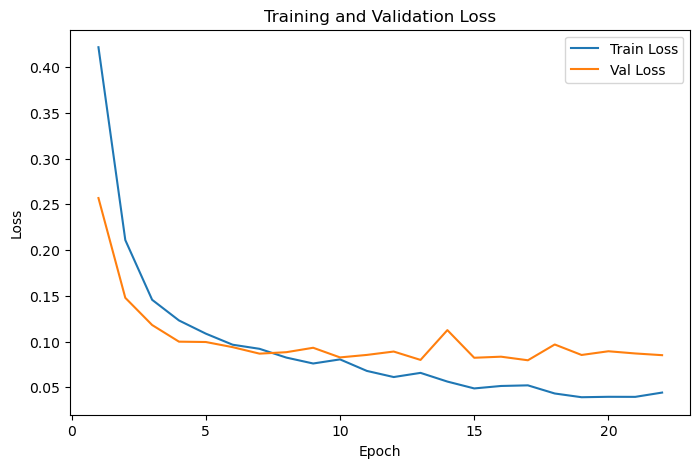

In [ ]:
def plot_training_history():
    epochs = range(1, len(train_losses_noaug) + 1)  

    plt.figure(figsize=(8, 5))

    # ---- Loss ----
    plt.subplot(1, 1, 1)
    plt.plot(epochs, train_losses_noaug, label='Train Loss')
    plt.plot(epochs, val_losses_noaug, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()



plot_training_history()


## ทดสอบ Model บน Test Data

ในส่วนนี้จะทำการ:

1. **โหลด Model ทั้งสองแบบ** - โหลด Augmented Model และ Non-Augmented Model จากไฟล์ checkpoint
2. **ทดสอบบน Test Data** - ประเมินผลทั้งสอง model บน test dataset (870 รูป)
3. **สร้าง Confusion Matrix (Heatmap)** - แสดง Confusion Matrix เป็น heatmap ทั้งสองแบบ:
   - แสดงจำนวน True Positive, True Negative, False Positive, False Negative
4. **พิมพ์ Classification Report** - แสดง Precision, Recall, F1-Score สำหรับแต่ละ model
5. **สรุปเปรียบเทียบ** - สรุปผลการทดสอบและเปรียบเทียบความแม่นยำของ Augmented vs Non-Augmented Model

In [25]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# ==================== LOAD BOTH MODELS ====================
# Load augmented model
checkpoint_aug = torch.load('best_model_aug.pth', map_location=device, weights_only=False)
model_aug = TinyCNN().to(device)
model_aug.load_state_dict(checkpoint_aug['model_state_dict'])
model_aug.eval()

# Load non-augmented model
checkpoint_noaug = torch.load('best_model_noaug.pth', map_location=device, weights_only=False)
model_noaug = TinyCNN().to(device)
model_noaug.load_state_dict(checkpoint_noaug['model_state_dict'])
model_noaug.eval()

print("Both models loaded successfully!")

Both models loaded successfully!


In [26]:
# ==================== TEST BOTH MODELS ====================
def evaluate_model(model, test_loader, model_name):
    """Evaluate model on test data and return predictions + labels"""
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Testing {model_name}"):
            images = images.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    
    return np.array(all_preds), np.array(all_labels)

# Evaluate both models
preds_aug, labels_test_aug = evaluate_model(model_aug, test_loader_rgb, "Augmented Model")
preds_noaug, labels_test_noaug = evaluate_model(model_noaug, test_loader_rgb, "Non-Augmented Model")

print("Test evaluation completed for both models!")


Testing Augmented Model:   0%|          | 0/7 [00:00<?, ?it/s]

Testing Non-Augmented Model: 100%|██████████| 7/7 [00:51<00:00,  7.42s/it]

Test evaluation completed for both models!


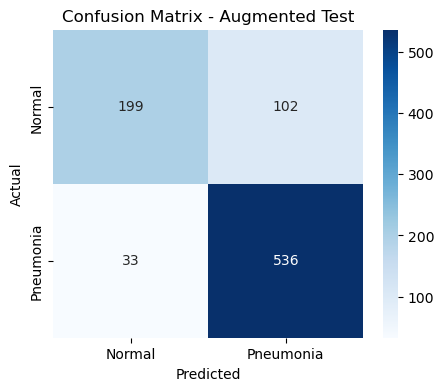

In [25]:
# -------------------- Confusion Matrix (Augmented) --------------------
cm_aug = confusion_matrix(labels_test_aug, preds_aug)
plt.figure(figsize=(5,4))
sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Blues',
			xticklabels=['Normal', 'Pneumonia'],
			yticklabels=['Normal', 'Pneumonia'])
plt.title("Confusion Matrix - Augmented Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

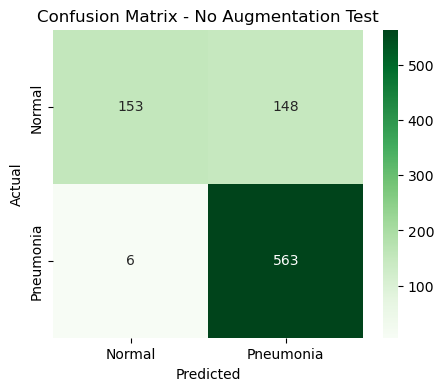

In [ ]:
# -------------------- Confusion Matrix (No Augmentation) --------------------
cm_noaug = confusion_matrix(labels_test_noaug, preds_noaug)  
plt.figure(figsize=(5,4))
sns.heatmap(cm_noaug, annot=True, fmt='d', cmap='Greens',
			xticklabels=['Normal', 'Pneumonia'],
			yticklabels=['Normal', 'Pneumonia'])
plt.title("Confusion Matrix - No Augmentation Test")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [27]:
# ==================== CLASSIFICATION REPORT ====================
print("="*70)
print("AUGMENTED MODEL - CLASSIFICATION REPORT")
print("="*70)
print(classification_report(labels_test_aug, preds_aug, 
                          target_names=['Normal', 'Pneumonia'],
                          digits=4))

print("\n" + "="*70)
print("NON-AUGMENTED MODEL - CLASSIFICATION REPORT")
print("="*70)
print(classification_report(labels_test_noaug, preds_noaug, 
                          target_names=['Normal', 'Pneumonia'],
                          digits=4))


AUGMENTED MODEL - CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Normal     0.8578    0.6611    0.7467       301
   Pneumonia     0.8401    0.9420    0.8882       569

    accuracy                         0.8448       870
   macro avg     0.8489    0.8016    0.8174       870
weighted avg     0.8462    0.8448    0.8392       870


NON-AUGMENTED MODEL - CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Normal     0.9623    0.5083    0.6652       301
   Pneumonia     0.7918    0.9895    0.8797       569

    accuracy                         0.8230       870
   macro avg     0.8771    0.7489    0.7725       870
weighted avg     0.8508    0.8230    0.8055       870



In [28]:
# ==================== SUMMARY COMPARISON ====================
acc_aug = accuracy_score(labels_test_aug, preds_aug)
acc_noaug = accuracy_score(labels_test_noaug, preds_noaug)

print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(f"{'Metric':<30} {'Augmented Model':<20} {'Non-Augmented Model':<20}")
print("-"*70)
print(f"{'Test Accuracy':<30} {acc_aug:.4f} {' '*14} {acc_noaug:.4f}")
print(f"{'TP (Pneumonia Detected)':<30} {cm_aug[1,1]:<20} {cm_noaug[1,1]:<20}")
print(f"{'FN (Pneumonia Missed)':<30} {cm_aug[1,0]:<20} {cm_noaug[1,0]:<20}")
print(f"{'FP (False Alarm)':<30} {cm_aug[0,1]:<20} {cm_noaug[0,1]:<20}")
print(f"{'TN (Normal Correct)':<30} {cm_aug[0,0]:<20} {cm_noaug[0,0]:<20}")
print("="*70)

# Determine which model is better
if acc_aug > acc_noaug:
    print(f"\n AUGMENTED MODEL is better with {(acc_aug-acc_noaug)*100:.2f}% higher accuracy")
elif acc_noaug > acc_aug:
    print(f"\n NON-AUGMENTED MODEL is better with {(acc_noaug-acc_aug)*100:.2f}% higher accuracy")
else:
    print(f"\n Both models have the same accuracy: {acc_aug:.4f}")



MODEL COMPARISON SUMMARY
Metric                         Augmented Model      Non-Augmented Model 
----------------------------------------------------------------------
Test Accuracy                  0.8448                0.8230
TP (Pneumonia Detected)        536                  563                 
FN (Pneumonia Missed)          33                   6                   
FP (False Alarm)               102                  148                 
TN (Normal Correct)            199                  153                 

 AUGMENTED MODEL is better with 2.18% higher accuracy


# สรุปผลการทดลอง

## ข้อมูล
- **Train**: 7,084 ภาพ (Balanced: 3,200 Normal + 3,900 Pneumonia)
- **Validation**: 870 ภาพ
- **Test**: 870 ภาพ

## Model CNN (RGB)
**TinyCNN**: Input 1 channel (RGB) 224×224
- Conv1 (3→8), Conv2 (8→16) + MaxPool ×2
- FC: 16×56×56 → 64 → 1 (Binary Classification)
- Optimizer: Adam (lr=1e-4), Loss: BCEWithLogitsLoss

---

## Model with Augmentation (Aug)
**Data Augmentation**: Flip, Rotate(12°), Translate(5%)
- **Epochs**: 8 (Early stopping at epoch 8)
- **Best Val Loss**: 0.1455 (epoch 3)
- **Test Accuracy**: 0.8448 (84.48%)
- **Test Recall (Pneumonia)**: 0.9420 (94.20%)
- **Train Loss**: 0.1551 (epoch 8) → **Val Loss**: 0.1750
- **TP**: 536, **FN**: 33 (เหมาะสำหรับ Medical - ลด False Negative)

---

## Model without Augmentation (NoAug)
**No Data Augmentation**
- **Epochs**: 22 (Early stopping at epoch 22)
- **Best Val Loss**: 0.0796 (epoch 17)
- **Test Accuracy**: 0.8230 (82.30%)
- **Test Recall (Pneumonia)**:  0.9895 (98.95%) 
- **Train Loss**: 0.0443 (epoch 22) → **Val Loss**: 0.0852
- **TP**: 563, **FN**: 6 (ยอด - ลด False Negative มากที่สุด!)

---

## Best Model: **NoAug Model**
| Metric | NoAug | Aug |
|--------|-------|-----|
| **Recall** | **98.95%** | 94.20% |
| **FN (Missed)** | **6** | 33 |
| **Test Acc** | 82.30% | 84.48% |
| **TP** | 563 | 536 |

**เหตุผล**: NoAug Model ดีกว่าเพราะ **Recall สูงสุด (98.95%)** - ลด False Negative เหลือ 6 รายการ เหมาะสำหรับการวินิจฉัย Pneumonia ในการแพทย์ที่ต้องหลีกเลี่ยงการพลาดผู้ป่วย